# 4DOF Cart-Pole System Model - Rotation

Theoretical mathematical model of the 4DOF cart-pole system in the coordinate system $ (x, y, \theta, \varphi) $ with wheels' angular velocity as free variables.

Dynamic model uses Euler-Lagrange equations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from IPython.display import display, Math, Latex
from scipy.integrate import solve_ivp

 ## Model

In [2]:
# Constants
sp_half = sp.Rational(1, 2)

# Define symbols
hb, hr, hbc, eb, ew, dw = sp.symbols(r'h_b, h_r, h_bc, e_b, e_w, d_w', constant=True)
m, Ir, Iz, Iw, ba, bd, ct, rho, g = sp.symbols(r'm, I_r, I_z, I_w, b_a, b_d, c_{\theta}, \rho, g', constant=True)

t = sp.symbols(r't')

# omega_l = sp.Function(r'\omega_l')(t)
# omega_r = sp.Function(r'\omega_r')(t)
omega_l = sp.symbols(r'\omega_l', constant=True)
omega_r = sp.symbols(r'\omega_r', constant=True)

v = sp.Function(r'v')(t)

x = sp.Function(r'x')(t)
y = sp.Function(r'y')(t)
theta = sp.Function(r'\theta')(t)
phi = sp.Function(r'\varphi')(t)

x_dot = x.diff(t)
y_dot = y.diff(t)
theta_dot = theta.diff(t)
phi_dot = phi.diff(t)

x_ddot = x_dot.diff(t)
y_ddot = y_dot.diff(t)
theta_ddot = theta_dot.diff(t)
phi_ddot = phi_dot.diff(t)

plane_dir = sp.Matrix([sp.cos(phi), sp.sin(phi), 0])

### Kinematic model

#### Kinematics of the body's left wheel

In [3]:
Xl_dot_norm = (omega_l + theta_dot) * dw / 2

# Output
Xl_dot_norm = sp.simplify(Xl_dot_norm)
display(Xl_dot_norm)

d_w*(\omega_l + Derivative(\theta(t), t))/2

In [4]:
Xl_dot = Xl_dot_norm * plane_dir

# Output
Xl_dot = sp.simplify(Xl_dot)
display(Xl_dot)

Matrix([
[d_w*(\omega_l + Derivative(\theta(t), t))*cos(\varphi(t))/2],
[d_w*(\omega_l + Derivative(\theta(t), t))*sin(\varphi(t))/2],
[                                                          0]])

#### Kinematics of the body's right wheel

In [5]:
Xr_dot_norm = (omega_r + theta_dot) * dw / 2

# Output
Xr_dot_norm = sp.simplify(Xr_dot_norm)
display(Xr_dot_norm)

d_w*(\omega_r + Derivative(\theta(t), t))/2

In [6]:
Xr_dot = Xr_dot_norm * plane_dir

# Output
Xr_dot = sp.simplify(Xr_dot)
display(Xr_dot)

Matrix([
[d_w*(\omega_r + Derivative(\theta(t), t))*cos(\varphi(t))/2],
[d_w*(\omega_r + Derivative(\theta(t), t))*sin(\varphi(t))/2],
[                                                          0]])

#### Movement due to the wheels

In [7]:
v = sp_half * dw * (omega_l + omega_r) / 2
# phi_dot = (omega_l - omega_r) / 2

#### Kinematics of the body's origin

In [8]:
Xo = sp.Function('X_o')(t)

In [9]:
Xo = sp.Matrix([
    x,  # + sp.integrate(v * sp.cos(phi), (t, 0, t)),
    y,  # + sp.integrate(v * sp.sin(phi), (t, 0, t)),
    0
])

# Output
Xo = sp.simplify(Xo)
display(Xo)

Matrix([
[x(t)],
[y(t)],
[   0]])

In [10]:
Xo_dot = Xo.diff(t) + v * plane_dir

# Output
Xo_dot = sp.simplify(Xo_dot)
display(Xo_dot)

Matrix([
[d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 + Derivative(x(t), t)],
[d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 + Derivative(y(t), t)],
[                                                                0]])

#### Kinematics of the body's center of mass

In [11]:
Xco = sp.Function('X_c')(t)
Xc = sp.Function('X_c')(t)

In [12]:
Xco = sp.rot_givens(1, 0, phi) * (sp.rot_givens(0, 2, theta) * sp.Matrix([0, 0, hbc]))

Xc = Xo + Xco

# Output
Xc = sp.simplify(Xc)
display(Xc)

Matrix([
[h_bc*sin(\theta(t))*cos(\varphi(t)) + x(t)],
[h_bc*sin(\theta(t))*sin(\varphi(t)) + y(t)],
[                       h_bc*cos(\theta(t))]])

In [13]:
# TODO: Analyze the correct approach to Xc_dot

# Xc_dot = Xo_dot + Xco.diff(t)

omegao = sp.Matrix([
    0,
    theta_dot,
    phi_dot,
])

omegac = sp.rot_givens(1, 0, phi) * (sp.rot_givens(0, 2, theta) * omegao)
Xc_dot = Xo_dot + omegac.cross(Xco)

# Output
Xc_dot = sp.simplify(Xc_dot)
display(Xc_dot)

Matrix([
[\omega_l*d_w*cos(\varphi(t))/4 + \omega_r*d_w*cos(\varphi(t))/4 + h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t)],
[\omega_l*d_w*sin(\varphi(t))/4 + \omega_r*d_w*sin(\varphi(t))/4 + h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t)],
[                                                                                                       -h_bc*sin(\theta(t))*Derivative(\theta(t), t)]])

In [14]:
Xc_dot_norm = sp.sqrt(Xc_dot.dot(Xc_dot))

# Output
Xc_dot_norm = sp.simplify(Xc_dot_norm)
display(Xc_dot_norm)

sqrt(16*h_bc**2*sin(\theta(t))**2*Derivative(\theta(t), t)**2 + (\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))**2 + (\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))**2)/4

### Dynamic model

#### Kinect energy of the body

Assuming the hypothesis $ \frac{ 2 ||\dot{X_l}|| }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [15]:
T = (
        sp_half * m * Xc_dot_norm ** 2
        + sp_half * Ir * theta_dot ** 2
        + sp_half * (Iz + m * (hbc * sp.sin(theta)) ** 2) * phi_dot ** 2
        + sp_half * Iw * ((omega_l + theta_dot) ** 2 + (omega_r + theta_dot) ** 2 + ct * 2 * theta_dot ** 2)
)

# Output
T_exp = sp.expand(T)
T = sp.simplify(T_exp)
display(T)

I_r*Derivative(\theta(t), t)**2/2 + I_w*\omega_l**2/2 + I_w*\omega_l*Derivative(\theta(t), t) + I_w*\omega_r**2/2 + I_w*\omega_r*Derivative(\theta(t), t) + I_w*c_{\theta}*Derivative(\theta(t), t)**2 + I_w*Derivative(\theta(t), t)**2 + I_z*Derivative(\varphi(t), t)**2/2 + \omega_l**2*d_w**2*m/32 + \omega_l*\omega_r*d_w**2*m/16 + \omega_l*d_w*h_bc*m*cos(\theta(t))*Derivative(\theta(t), t)/4 + \omega_l*d_w*m*sin(\varphi(t))*Derivative(y(t), t)/4 + \omega_l*d_w*m*cos(\varphi(t))*Derivative(x(t), t)/4 + \omega_r**2*d_w**2*m/32 + \omega_r*d_w*h_bc*m*cos(\theta(t))*Derivative(\theta(t), t)/4 + \omega_r*d_w*m*sin(\varphi(t))*Derivative(y(t), t)/4 + \omega_r*d_w*m*cos(\varphi(t))*Derivative(x(t), t)/4 + h_bc**2*m*sin(\theta(t))**2*Derivative(\varphi(t), t)**2/2 + h_bc**2*m*Derivative(\theta(t), t)**2/2 + h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(y(t), t) + h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)*Derivative(x(t), t) + m*Derivative(x(t), t)**

In [16]:
T_gradq = sp.Matrix([
    T_exp.diff(x),
    T_exp.diff(y),
    T_exp.diff(theta),
    T_exp.diff(phi),
])

# Output
T_gradq_exp = sp.expand(T_gradq)
T_gradq = sp.simplify(T_gradq_exp)
display(T_gradq)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                         0],
[                                                                                                                                                                                                                                                                                                                                                                                         0],
[                                                                                           h_bc*m*(-\omega_l*d_w*Derivative(\theta(t), t) - \omega_r*d_w*Derivative(\theta(t), t) + 4*h_bc*cos(\theta(t))*Derivative(\varphi(t), t

In [17]:
T_gradqd = sp.Matrix([
    T_exp.diff(x_dot),
    T_exp.diff(y_dot),
    T_exp.diff(theta_dot),
    T_exp.diff(phi_dot),
])

# Output
T_gradqd_exp = sp.expand(T_gradqd)
T_gradqd = sp.simplify(T_gradqd_exp)
display(T_gradqd)

Matrix([
[                                                                                                                                                                                                                        m*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))/4],
[                                                                                                                                                                                                                        m*(\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))/4],
[I_r*Derivative(\theta(t), t) + I_w*\omega_l + I_w*\omega_r + 2*I_w*c_{\theta}*Derivative(\theta(t), t) + 2*I_w*Derivative(\theta(t), t) + \omega_l*d_w*h_bc*m*cos(\theta(t))/4 + \omega_r*d_w*h_bc*m*cos(\theta(t))/4 + h_bc**2*m*Derivative(\thet

In [18]:
T_gradqd_dot = T_gradqd_exp.diff(t)

# Output
T_gradqd_dot_exp = sp.expand(T_gradqd_dot)
T_gradqd_dot = sp.simplify(T_gradqd_dot_exp)
display(T_gradqd_dot)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                  m*(-\omega_l*d_w*sin(\varphi(t))*Derivative(\varphi(t), t) - \omega_r*d_w*sin(\varphi(t))*Derivative(\varphi(t), t) - 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 - 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), (t, 2)) + 4*Derivative(x(t), (t, 2)))/4],
[                                                                                                                                                                                                                                

#### Potential energy of the body

In [19]:
V = m * g * Xc.dot(sp.Matrix([0, 0, 1]))

# Output
V = sp.simplify(V)
display(V)

g*h_bc*m*cos(\theta(t))

In [20]:
V_gradq = sp.Matrix([
    V.diff(x),
    V.diff(y),
    V.diff(theta),
    V.diff(phi),
])

# Output
V_gradq = sp.simplify(V_gradq)
display(V_gradq)

Matrix([
[                       0],
[                       0],
[-g*h_bc*m*sin(\theta(t))],
[                       0]])

In [21]:
V_gradqd = sp.Matrix([
    V.diff(x_dot),
    V.diff(y_dot),
    V.diff(theta_dot),
    V.diff(phi_dot),
])

# Output
V_gradqd = sp.simplify(V_gradqd)
display(V_gradqd)

Matrix([
[0],
[0],
[0],
[0]])

In [22]:
V_gradqd_dot = V_gradqd.diff(t)

# Output
V_gradqd_dot = sp.simplify(V_gradqd_dot)
display(V_gradqd_dot)

Matrix([
[0],
[0],
[0],
[0]])

#### Dissipation energy of the body

Assuming the hypothesis of no slip, then the dissipation from the wheel-ground contact $ D_w $ is zero.

Dissipation from the axle $ D_a $.

Assuming the hypothesis $ \frac{ 2 ||\dot{X_l}|| }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [23]:
Da = sp_half * ba * (
        (omega_l + theta_dot) ** 2
        + (omega_r + theta_dot) ** 2
        + ct * 2 * theta_dot ** 2
)

# Output
Da_exp = sp.expand(Da)
Da = sp.simplify(Da_exp)
display(Da)

b_a*(\omega_l**2 + 2*\omega_l*Derivative(\theta(t), t) + \omega_r**2 + 2*\omega_r*Derivative(\theta(t), t) + 2*c_{\theta}*Derivative(\theta(t), t)**2 + 2*Derivative(\theta(t), t)**2)/2

In [24]:
D = Da

# Output
D = sp.simplify(D)
display(D)

b_a*(\omega_l**2 + 2*\omega_l*Derivative(\theta(t), t) + \omega_r**2 + 2*\omega_r*Derivative(\theta(t), t) + 2*c_{\theta}*Derivative(\theta(t), t)**2 + 2*Derivative(\theta(t), t)**2)/2

In [25]:
D_gradq = sp.Matrix([
    D.diff(x),
    D.diff(y),
    D.diff(theta),
    D.diff(phi),
])

# Output
D_gradq = sp.simplify(D_gradq)
display(D_gradq)

Matrix([
[0],
[0],
[0],
[0]])

In [26]:
D_gradqd = sp.Matrix([
    D.diff(x_dot),
    D.diff(y_dot),
    D.diff(theta_dot),
    D.diff(phi_dot),
])

# Output
D_gradqd = sp.simplify(D_gradqd)
display(D_gradqd)

Matrix([
[                                                                                             0],
[                                                                                             0],
[b_a*(\omega_l + \omega_r + 2*c_{\theta}*Derivative(\theta(t), t) + 2*Derivative(\theta(t), t))],
[                                                                                             0]])

#### External forces

Air drag $ E_d $ with executed work $ Q_d $. Assuming the hypothesis of the air relative velocity being small, we can take the first-order approximation $ x^2 \approx x $.

In [27]:
Xair_dot = Xc_dot + hbc * theta_dot * sp.Matrix([sp.sin(theta) * sp.cos(phi), sp.sin(theta) * sp.sin(phi), sp.cos(theta)])
Xair_dot = Xc_dot
Ed = - sp_half * rho * bd * Xair_dot

# Output
Ed = sp.simplify(Ed)
display(Ed)

Matrix([
[-\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))/8],
[-\rho*b_d*(\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))/8],
[                                                                                                           \rho*b_d*h_bc*sin(\theta(t))*Derivative(\theta(t), t)/2]])

In [28]:
Qd_gradq = sp.Matrix([
    Ed.dot(Xc.diff(x)),
    Ed.dot(Xc.diff(y)),
    Ed.dot(Xc.diff(theta)),
    Ed.dot(Xc.diff(phi)),
])

# Output
Qd_gradq = sp.simplify(Qd_gradq)
display(Qd_gradq)

Matrix([
[                                                          -\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))/8],
[                                                          -\rho*b_d*(\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))/8],
[-\rho*b_d*h_bc*(\omega_l*d_w*cos(\theta(t)) + \omega_r*d_w*cos(\theta(t)) + 4*h_bc*Derivative(\theta(t), t) + 4*sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t) + 4*cos(\theta(t))*cos(\varphi(t))*Derivative(x(t), t))/8],
[                                                                                                                  \rho*b_d*h_bc*(sin(\varphi(t))*Derivative(x(t), t) - cos(\varphi(t))*Derivative(y(t), t))*sin(\theta(t))/2]])

In [29]:
Q_gradq = Qd_gradq
Q_gradq

Matrix([
[                                                          -\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))/8],
[                                                          -\rho*b_d*(\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))/8],
[-\rho*b_d*h_bc*(\omega_l*d_w*cos(\theta(t)) + \omega_r*d_w*cos(\theta(t)) + 4*h_bc*Derivative(\theta(t), t) + 4*sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t) + 4*cos(\theta(t))*cos(\varphi(t))*Derivative(x(t), t))/8],
[                                                                                                                  \rho*b_d*h_bc*(sin(\varphi(t))*Derivative(x(t), t) - cos(\varphi(t))*Derivative(y(t), t))*sin(\theta(t))/2]])

#### Lagrangian

In [30]:
L = T - V

# Output
L = sp.simplify(L)
display(L)

I_r*Derivative(\theta(t), t)**2/2 + I_w*\omega_l**2/2 + I_w*\omega_l*Derivative(\theta(t), t) + I_w*\omega_r**2/2 + I_w*\omega_r*Derivative(\theta(t), t) + I_w*c_{\theta}*Derivative(\theta(t), t)**2 + I_w*Derivative(\theta(t), t)**2 + I_z*Derivative(\varphi(t), t)**2/2 + \omega_l**2*d_w**2*m/32 + \omega_l*\omega_r*d_w**2*m/16 + \omega_l*d_w*h_bc*m*cos(\theta(t))*Derivative(\theta(t), t)/4 + \omega_l*d_w*m*sin(\varphi(t))*Derivative(y(t), t)/4 + \omega_l*d_w*m*cos(\varphi(t))*Derivative(x(t), t)/4 + \omega_r**2*d_w**2*m/32 + \omega_r*d_w*h_bc*m*cos(\theta(t))*Derivative(\theta(t), t)/4 + \omega_r*d_w*m*sin(\varphi(t))*Derivative(y(t), t)/4 + \omega_r*d_w*m*cos(\varphi(t))*Derivative(x(t), t)/4 - g*h_bc*m*cos(\theta(t)) + h_bc**2*m*sin(\theta(t))**2*Derivative(\varphi(t), t)**2/2 + h_bc**2*m*Derivative(\theta(t), t)**2/2 + h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(y(t), t) + h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)*Derivative(x(t), t)

#### Compiled model

In [31]:
model = (T_gradqd_dot - V_gradqd_dot) - (T_gradq - V_gradq) + D_gradqd - Q_gradq

# Output
model = sp.simplify(model)
display(model)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                          \rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))/8 - m*(\omega_l*d_w*sin(\varphi(t))*Derivative(\varphi(t), t) + \omega_r*d_w*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) - 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), (t, 2)) - 4*Derivative(x(t), (t, 2)))/4],
[                                                     

In [32]:
# Separate model into `M * Xi_ddot + H = Mii * Xi_ddot + Bi2 * Xi_dot**2 + Bij * Xi_dot * Xj_dot + Bi * Xi_dot + C + U` form
dim = len(model)
model_expand = sp.zeros(dim, 1)
for i, eq in enumerate(model):
    model_expand[i] = sp.expand(eq)

Xi_ddot = sp.Matrix([x_ddot, y_ddot, theta_ddot, phi_ddot])
Xi_dot = sp.Matrix([x_dot, y_dot, theta_dot, phi_dot])

Mii = sp.zeros(dim, dim)
Bi2 = sp.zeros(dim, dim)
Bij = sp.zeros(dim, dim)
Bi = sp.zeros(dim, dim)
C = sp.zeros(dim, 1)
U = sp.zeros(dim, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, xi_dot in enumerate(Xi_dot):
        Mii[i, j] = eq.coeff(Xi_ddot[j], 1)
        subs_list += [(Xi_ddot[j], 0)]

        Bi2[i, j] = eq.coeff(xi_dot, 2)
        subs_list += [(xi_dot ** 2, 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate second-order distinct derivatives
        all_dot = [term.has(d) for d in Xi_dot]
        idx_dot = [i for i in range(len(all_dot)) if all_dot[i] == True]
        xi_dot = [d for d in all_dot if d == True]
        if len(idx_dot) == 2:
            for j in idx_dot:
                Bij[i, j] += term.coeff(Xi_dot[j], 1) / len(idx_dot)
                subs_list += [(term.coeff(Xi_dot[j], 1), 0)]

        # Isolate first-order linear derivatives
        for j, xi_dot in enumerate(Xi_dot):
            if term.count(xi_dot) == 1:
                other_derivs = [x for x in Xi_dot if x != xi_dot]
                if not any(term.has(od) for od in other_derivs):
                    Bi[i, j] += term.coeff(xi_dot, 1)
                    subs_list += [(term.coeff(xi_dot, 1), 0)]

        # Isolate zero-order derivatives
        if (sum(term.count(xi_ddot) for xi_ddot in Xi_ddot) == 0) and (sum(term.count(xi_dot) for xi_dot in Xi_dot) == 0):
            C[i] += term
            subs_list += [(term, 0)]

    model_expand[i] = eq.subs(subs_list)
    model_expand[i] = sp.expand(model_expand[i])

# Output
Mii = sp.simplify(Mii)
Bi2 = sp.simplify(Bi2)
Bij = sp.simplify(Bij)
Bi = sp.simplify(Bi)
C = sp.simplify(C)
U = sp.simplify(model - (Mii * Xi_ddot + Bi2 * sp.Matrix([e ** 2 for e in Xi_dot]) + Bij * Xi_dot + Bi * Xi_dot + C))

display(Mii)
display(Bi2)
display(Bij)
display(Bi)
display(C)
display(U)

# Verification
model_is_simplified = sp.simplify((Mii * Xi_ddot + Bi2 * sp.Matrix([xi_dot ** 2 for xi_dot in Xi_dot]) + Bij * Xi_dot + Bi * Xi_dot + C + U) - model) == sp.Matrix(dim * [0])
print(model_is_simplified)

Matrix([
[                                    m,                                     0,      h_bc*m*cos(\theta(t))*cos(\varphi(t)),                                 0],
[                                    0,                                     m,      h_bc*m*sin(\varphi(t))*cos(\theta(t)),                                 0],
[h_bc*m*cos(\theta(t))*cos(\varphi(t)), h_bc*m*sin(\varphi(t))*cos(\theta(t)), I_r + 2*I_w*c_{\theta} + 2*I_w + h_bc**2*m,                                 0],
[                                    0,                                     0,                                          0, I_z + h_bc**2*m*sin(\theta(t))**2]])

Matrix([
[0, 0, -h_bc*m*sin(\theta(t))*cos(\varphi(t)),                             0],
[0, 0, -h_bc*m*sin(\theta(t))*sin(\varphi(t)),                             0],
[0, 0,                                      0, -h_bc**2*m*sin(2*\theta(t))/2],
[0, 0,                                      0,                             0]])

Matrix([
[                                                                 0,                                                                 0,                                                                                    -h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t)/2,                                    -h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)/2],
[                                                                 0,                                                                 0,                                                                                     h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)/2,                                     h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)/2],
[-h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t)/2, h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)/2,                                                                            

Matrix([
[                                                                          \rho*b_d/2,                                                                                     0, \rho*b_d*h_bc*cos(\theta(t))*cos(\varphi(t))/2, d_w*m*(-\omega_l - \omega_r)*sin(\varphi(t))/4],
[                                                                                   0,                                                                            \rho*b_d/2, \rho*b_d*h_bc*sin(\varphi(t))*cos(\theta(t))/2,  d_w*m*(\omega_l + \omega_r)*cos(\varphi(t))/4],
[                                      \rho*b_d*h_bc*cos(\theta(t))*cos(\varphi(t))/2,                                        \rho*b_d*h_bc*sin(\varphi(t))*cos(\theta(t))/2,  \rho*b_d*h_bc**2/2 + 2*b_a*c_{\theta} + 2*b_a,                                              0],
[(\omega_l*d_w*m + \omega_r*d_w*m - 2*\rho*b_d*h_bc*sin(\theta(t)))*sin(\varphi(t))/4, (-\omega_l*d_w*m - \omega_r*d_w*m + 2*\rho*b_d*h_bc*sin(\theta(t)))*cos(\varphi(t))/4,     

Matrix([
[                                                                                             \rho*b_d*d_w*(\omega_l + \omega_r)*cos(\varphi(t))/8],
[                                                                                             \rho*b_d*d_w*(\omega_l + \omega_r)*sin(\varphi(t))/8],
[\omega_l*\rho*b_d*d_w*h_bc*cos(\theta(t))/8 + \omega_l*b_a + \omega_r*\rho*b_d*d_w*h_bc*cos(\theta(t))/8 + \omega_r*b_a - g*h_bc*m*sin(\theta(t))],
[                                                                                                                                                0]])

Matrix([
[0],
[0],
[0],
[0]])

True


## Project

### Applied dynamic model

In [33]:
# TODO: Fix and solve for v

params = {
    hbc: 8.0e-2,  # height of body center
    eb: 8.0e-2,  # body width
    dw: 14.5e-2,  # wheel diameter
    m: 0.700,  # mass in kg
    Ir: 0.005,  # moment of inertia
    Iz: 0.002,  # moment of inertia
    Iw: 0.0005,  # moment of inertia
    ba: 0.01,  # damping coefficient
    bd: 0.002 * 0.01,  # drag coefficient
    ct: 1,  # theta_dot correction factor, ideally sp.tanh(theta_dot - (omega_l + omega_r))
    rho: 1.225,  # air density
    g: 9.81,  # gravity in m/s^2
    omega_l: 0,  # angular velocity of the cart's left wheel, free variable
    omega_r: 0,  # angular velocity of the cart's right wheel, free variable
}

In [34]:
# Substitutions are applied twice due to sympy failing to back-substitute.

args = [t, x, x_dot, y, y_dot, theta, theta_dot, phi, phi_dot]

Xo_sim = Xo.subs(params, simultaneous=True)
Xo_sim = sp.simplify(Xo_sim)
Xo_fn = sp.lambdify(args, Xo_sim)

Xo_dot_sim = Xo_dot.subs(params, simultaneous=True)
Xo_dot_sim = sp.simplify(Xo_dot_sim)
Xo_dot_fn = sp.lambdify(args, Xo_dot_sim)

Xc_sim = Xc.subs(params, simultaneous=True)
Xc_sim = sp.simplify(Xc_sim)
Xc_fn = sp.lambdify(args, Xc_sim)

Xc_dot_sim = Xc_dot.subs(params, simultaneous=True)
Xc_dot_sim = sp.simplify(Xc_dot_sim)
Xc_dot_fn = sp.lambdify(args, Xc_dot_sim)

M_sim = Mii.subs(params, simultaneous=True)
M_sim = sp.simplify(M_sim)
M_fn = sp.lambdify(args, M_sim)

H = Bi2 * sp.Matrix([e ** 2 for e in Xi_dot]) + Bij * Xi_dot + Bi * Xi_dot + C + U
H_sim = H.subs(params, simultaneous=True)
H_sim = sp.simplify(H_sim)
H_fn = sp.lambdify(args, H_sim)

# Output
model_sim = sp.simplify(M_sim * Xi_ddot + H_sim)
display(model_sim)

Matrix([
[                                                                                                                                                                                                                                  -0.056*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 - 0.056*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) + 9.8e-7*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 0.056*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), (t, 2)) + 1.225e-5*Derivative(x(t), t) + 0.7*Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                  -0.056*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t)**2 + 9.8e-7*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 0.056*sin(\varphi(t))*cos(\theta(t))*Derivative(\t

### Transfer function

To be done.

### Code generation

In [35]:
subs_code = {
    t: sp.Symbol(r"t", real=True),
    x: sp.Symbol(r"x", real=True),
    sp.Derivative(x, t): sp.Symbol(r"x_dot", real=True),
    sp.Derivative(x, (t, 2)): sp.Symbol(r"x_ddot", real=True),
    y: sp.Symbol(r"y", real=True),
    sp.Derivative(y, t): sp.Symbol(r"y_dot", real=True),
    sp.Derivative(y, (t, 2)): sp.Symbol(r"y_ddot", real=True),
    theta: sp.Symbol(r"theta", real=True),
    sp.Derivative(theta, t): sp.Symbol(r"theta_dot", real=True),
    sp.Derivative(theta, (t, 2)): sp.Symbol(r"theta_ddot", real=True),
    phi: sp.Symbol(r"phi", real=True),
    sp.Derivative(phi, t): sp.Symbol(r"phi_dot", real=True),
    sp.Derivative(phi, (t, 2)): sp.Symbol(r"phi_ddot", real=True),
}

In [36]:
Xc_code = Xc_sim.subs(subs_code)
Xc_code = sp.simplify(Xc_code)

# Output
display(sp.pycode(Xc_code, strict=False))

'ImmutableDenseMatrix([[x + 0.08*math.sin(theta)*math.cos(phi)], [y + 0.08*math.sin(phi)*math.sin(theta)], [0.08*math.cos(theta)]])'

In [37]:
Xc_dot_code = Xc_dot_sim.subs(subs_code)
Xc_dot_code = sp.simplify(Xc_dot_code)

# Output
display(sp.pycode(Xc_dot_code, strict=False))

'ImmutableDenseMatrix([[0.08*theta_dot*math.cos(phi)*math.cos(theta) + x_dot], [0.08*theta_dot*math.sin(phi)*math.cos(theta) + y_dot], [-0.08*theta_dot*math.sin(theta)]])'

In [38]:
M_code = M_sim.subs(subs_code)
M_code = sp.simplify(M_code)

# Output
display(sp.pycode(M_code, strict=False))

'ImmutableDenseMatrix([[0.7, 0, 0.056*math.cos(phi)*math.cos(theta), 0], [0, 0.7, 0.056*math.sin(phi)*math.cos(theta), 0], [0.056*math.cos(phi)*math.cos(theta), 0.056*math.sin(phi)*math.cos(theta), 0.01148, 0], [0, 0, 0, 0.00448*math.sin(theta)**2 + 0.002]])'

In [39]:
H_code = H_sim.subs(subs_code)
H_code = sp.simplify(H_code)

# Output
display(sp.pycode(H_code, strict=False))

'ImmutableDenseMatrix([[-0.056*phi_dot*theta_dot*math.sin(phi)*math.cos(theta) - 0.056*theta_dot**2*math.sin(theta)*math.cos(phi) + 9.8e-7*theta_dot*math.cos(phi)*math.cos(theta) + 1.225e-5*x_dot], [0.056*phi_dot*theta_dot*math.cos(phi)*math.cos(theta) - 0.056*theta_dot**2*math.sin(phi)*math.sin(theta) + 9.8e-7*theta_dot*math.sin(phi)*math.cos(theta) + 1.225e-5*y_dot], [-0.00224*phi_dot**2*math.sin(2*theta) - 0.056*phi_dot*x_dot*math.sin(phi)*math.cos(theta) + 0.056*phi_dot*y_dot*math.cos(phi)*math.cos(theta) + 0.0400000784*theta_dot + 9.8e-7*x_dot*math.cos(phi)*math.cos(theta) + 9.8e-7*y_dot*math.sin(phi)*math.cos(theta) - 0.54936*math.sin(theta)], [0.00448*phi_dot*theta_dot*math.sin(2*theta) + 0.056*theta_dot*x_dot*math.sin(phi)*math.cos(theta) - 0.056*theta_dot*y_dot*math.cos(phi)*math.cos(theta) - 9.8e-7*x_dot*math.sin(phi)*math.sin(theta) + 9.8e-7*y_dot*math.sin(theta)*math.cos(phi)]])'

In [40]:
def dynamics(t, f):
    M_num = np.array(M_fn(t, *f), dtype=float)
    H_num = np.array(H_fn(t, *f), dtype=float).flatten()

    xdd = np.linalg.lstsq(M_num, -H_num, rcond=1.0e-8)[0]

    return np.array([
        f[1],
        xdd[0],
        f[3],
        xdd[1],
        f[5],
        xdd[2],
        f[7],
        xdd[3],
    ])

### Simulation

In [41]:
f0 = [
    0.0, 0.0,
    0.0, 0.0,
    1.0e-8, 0.0,
    0.0, 0.0,
]

t_span = (0.0, 20.0)

sol = solve_ivp(
    dynamics,
    t_span=t_span, y0=f0,
    method='Radau',
    rtol=1.0e-8, atol=1.0e-9, max_step=1.0e-2,
)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  2.000e+01  2.000e+01]
        y: [[ 0.000e+00 -3.082e-12 ...  3.142e-10  3.141e-10]
            [ 0.000e+00 -6.110e-10 ... -2.860e-11 -2.860e-11]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 18860
     njev: 88
      nlu: 4002

In [42]:
sol_t = sol.t
sol_x, sol_x_dot, sol_y, sol_y_dot, sol_theta, sol_theta_dot, sol_phi, sol_phi_dot = sol.y

sol_xo = np.array([Xo_fn(sol.t[i], *sol.y[:, i]) for i in range(len(sol.t))]).reshape((len(sol.t), 3))
sol_xo_dot = np.array([Xo_dot_fn(sol.t[i], *sol.y[:, i]) for i in range(len(sol.t))]).reshape((len(sol.t), 3))
sol_xc = np.array([Xc_fn(sol.t[i], *sol.y[:, i]) for i in range(len(sol.t))]).reshape((len(sol.t), 3))
sol_xc_dot = np.array([Xc_dot_fn(sol.t[i], *sol.y[:, i]) for i in range(len(sol.t))]).reshape((len(sol.t), 3))

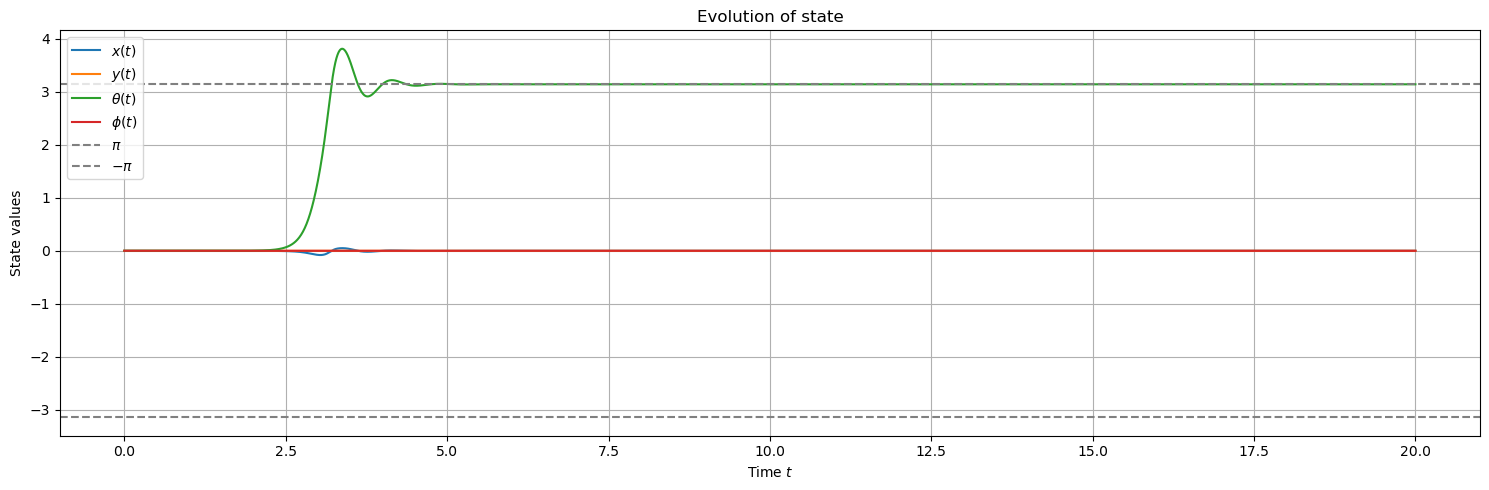

In [43]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_x, label=r'$x(t)$')
plt.plot(sol_t, sol_y, label=r'$y(t)$')
plt.plot(sol_t, sol_theta, label=r'$\theta(t)$')
plt.plot(sol_t, sol_phi, label=r'$\phi(t)$')

plt.axhline(y=np.pi, linestyle='--', color='gray', label=r'$\pi$')
plt.axhline(y=-np.pi, linestyle='--', color='gray', label=r'$-\pi$')


plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of state')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

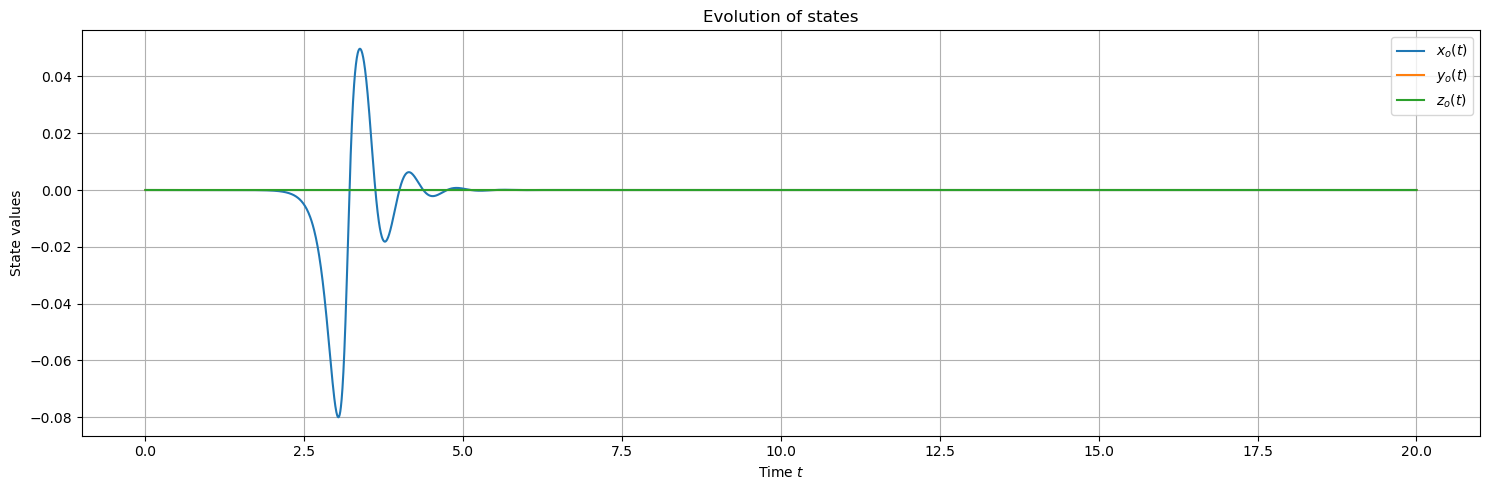

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_xo, label=[r'$x_o(t)$', r'$y_o(t)$', r'$z_o(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

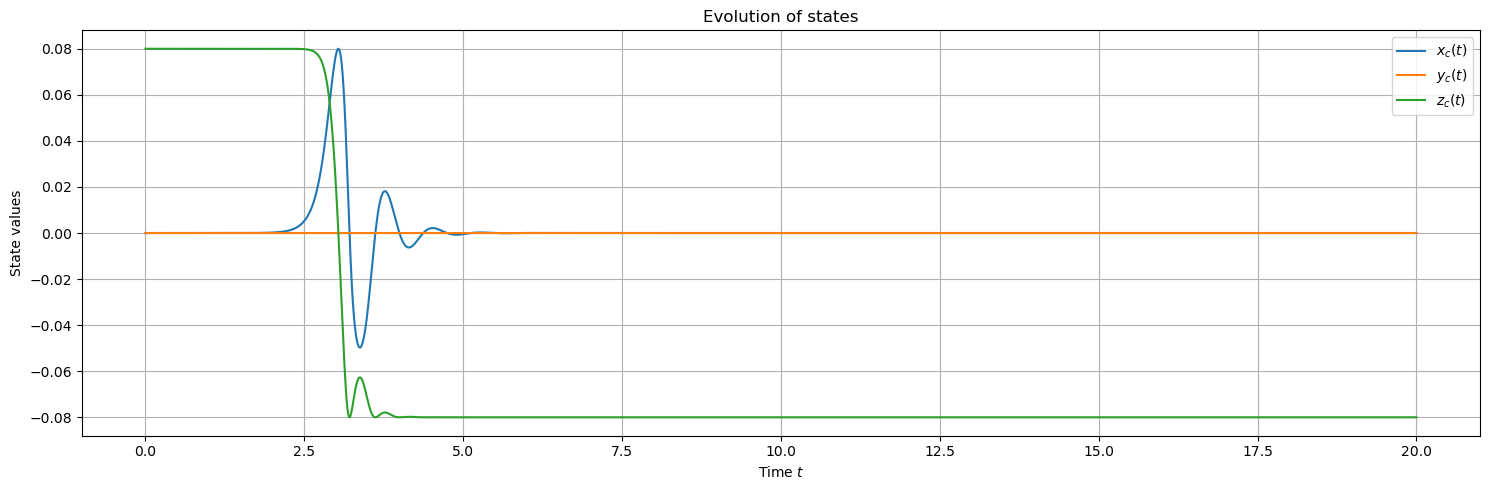

In [45]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_xc - sol_xo, label=[r'$x_c(t)$', r'$y_c(t)$', r'$z_c(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

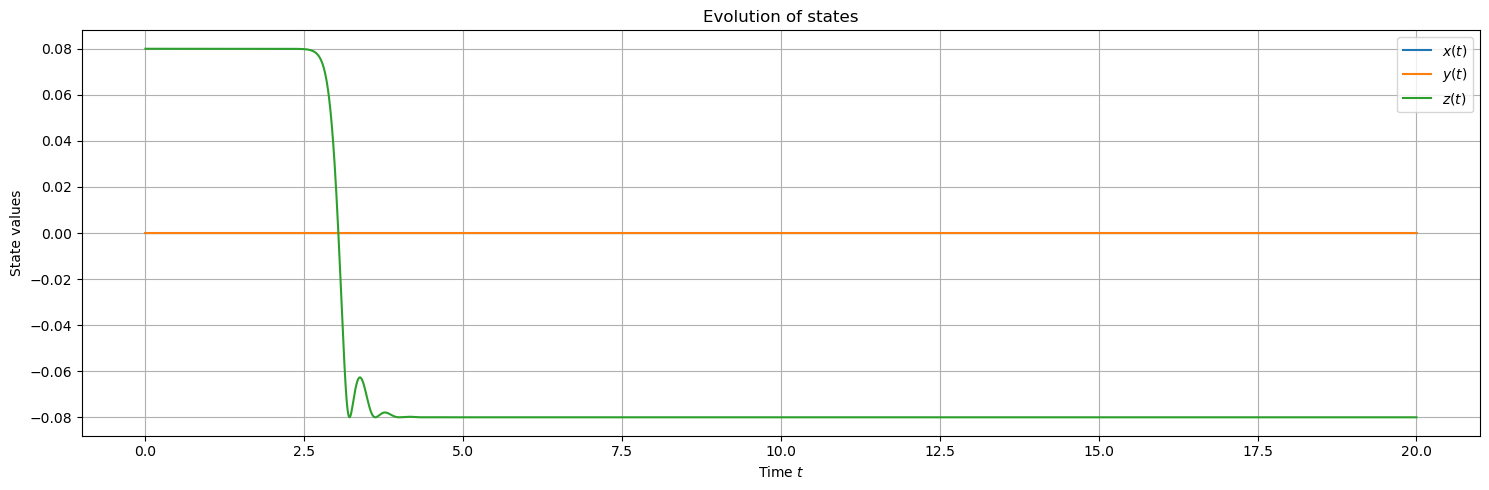

In [46]:
plt.figure(figsize=(15, 5))

plt.plot(sol.t, sol_xc, label=[r'$x(t)$', r'$y(t)$', r'$z(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()